<a href="https://colab.research.google.com/github/SarmenSinanian/DS-Unit-2-Regression-Classification/blob/master/Sarmen_Sinanian_Assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [31]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [35]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
# Making "month_created" column with the column 'created' being converted to datetime
df['SALE_DATE']= pd.to_datetime(df['SALE_DATE'])

In [0]:
# Creating columns with month/day/year separation
df['SALE_MONTH'] = df['SALE_DATE'].dt.month
df['SALE_YEAR'] = df['SALE_DATE'].dt.year
df['SALE_DAY'] = df['SALE_DATE'].dt.day

In [0]:
# df['SALE_PRICE'] = df['SALE_PRICE'].replace({0:np.nan}, inplace = True)

In [0]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

In [0]:
df2 = df[df['SALE_PRICE'] == 0]

In [0]:
df = df[df.SALE_PRICE != 0]

In [42]:
df.shape,df2.shape

((3380, 24), (1681, 24))

((3380, 24), (1681, 24))

In [0]:
mask_train = (df['SALE_MONTH'] >=1) & (df['SALE_MONTH'] <=3)
mask_test = (df['SALE_MONTH'] == 4)

df_train = df[mask_train]
df_test = df[mask_test]

In [44]:
df_train.shape, df_test.shape

((2704, 24), (676, 24))

((2704, 24), (676, 24))

In [45]:
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [46]:
df_numbers = df.select_dtypes('number')
df_numbers.dtypes

BOROUGH                        int64
BLOCK                          int64
LOT                            int64
EASE-MENT                    float64
ZIP_CODE                     float64
RESIDENTIAL_UNITS            float64
COMMERCIAL_UNITS             float64
TOTAL_UNITS                  float64
GROSS_SQUARE_FEET            float64
YEAR_BUILT                   float64
TAX_CLASS_AT_TIME_OF_SALE      int64
SALE_PRICE                     int64
SALE_MONTH                     int64
SALE_YEAR                      int64
SALE_DAY                       int64
dtype: object

BOROUGH                        int64
BLOCK                          int64
LOT                            int64
EASE-MENT                    float64
ZIP_CODE                     float64
RESIDENTIAL_UNITS            float64
COMMERCIAL_UNITS             float64
TOTAL_UNITS                  float64
GROSS_SQUARE_FEET            float64
YEAR_BUILT                   float64
TAX_CLASS_AT_TIME_OF_SALE      int64
SALE_PRICE                     int64
SALE_MONTH                     int64
SALE_YEAR                      int64
SALE_DAY                       int64
dtype: object

In [47]:
df_numbers.head()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_MONTH,SALE_YEAR,SALE_DAY
44,3,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,550000,1,2019,1
61,4,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,200000,1,2019,1
78,2,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,810000,1,2019,2
108,3,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,125000,1,2019,2
111,3,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,620000,1,2019,2


,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_MONTH,SALE_YEAR,SALE_DAY
44,3,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,550000,1,2019,1
61,4,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,200000,1,2019,1
78,2,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,810000,1,2019,2
108,3,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,125000,1,2019,2
111,3,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,620000,1,2019,2


# Do exploratory visualizations with Seaborn.

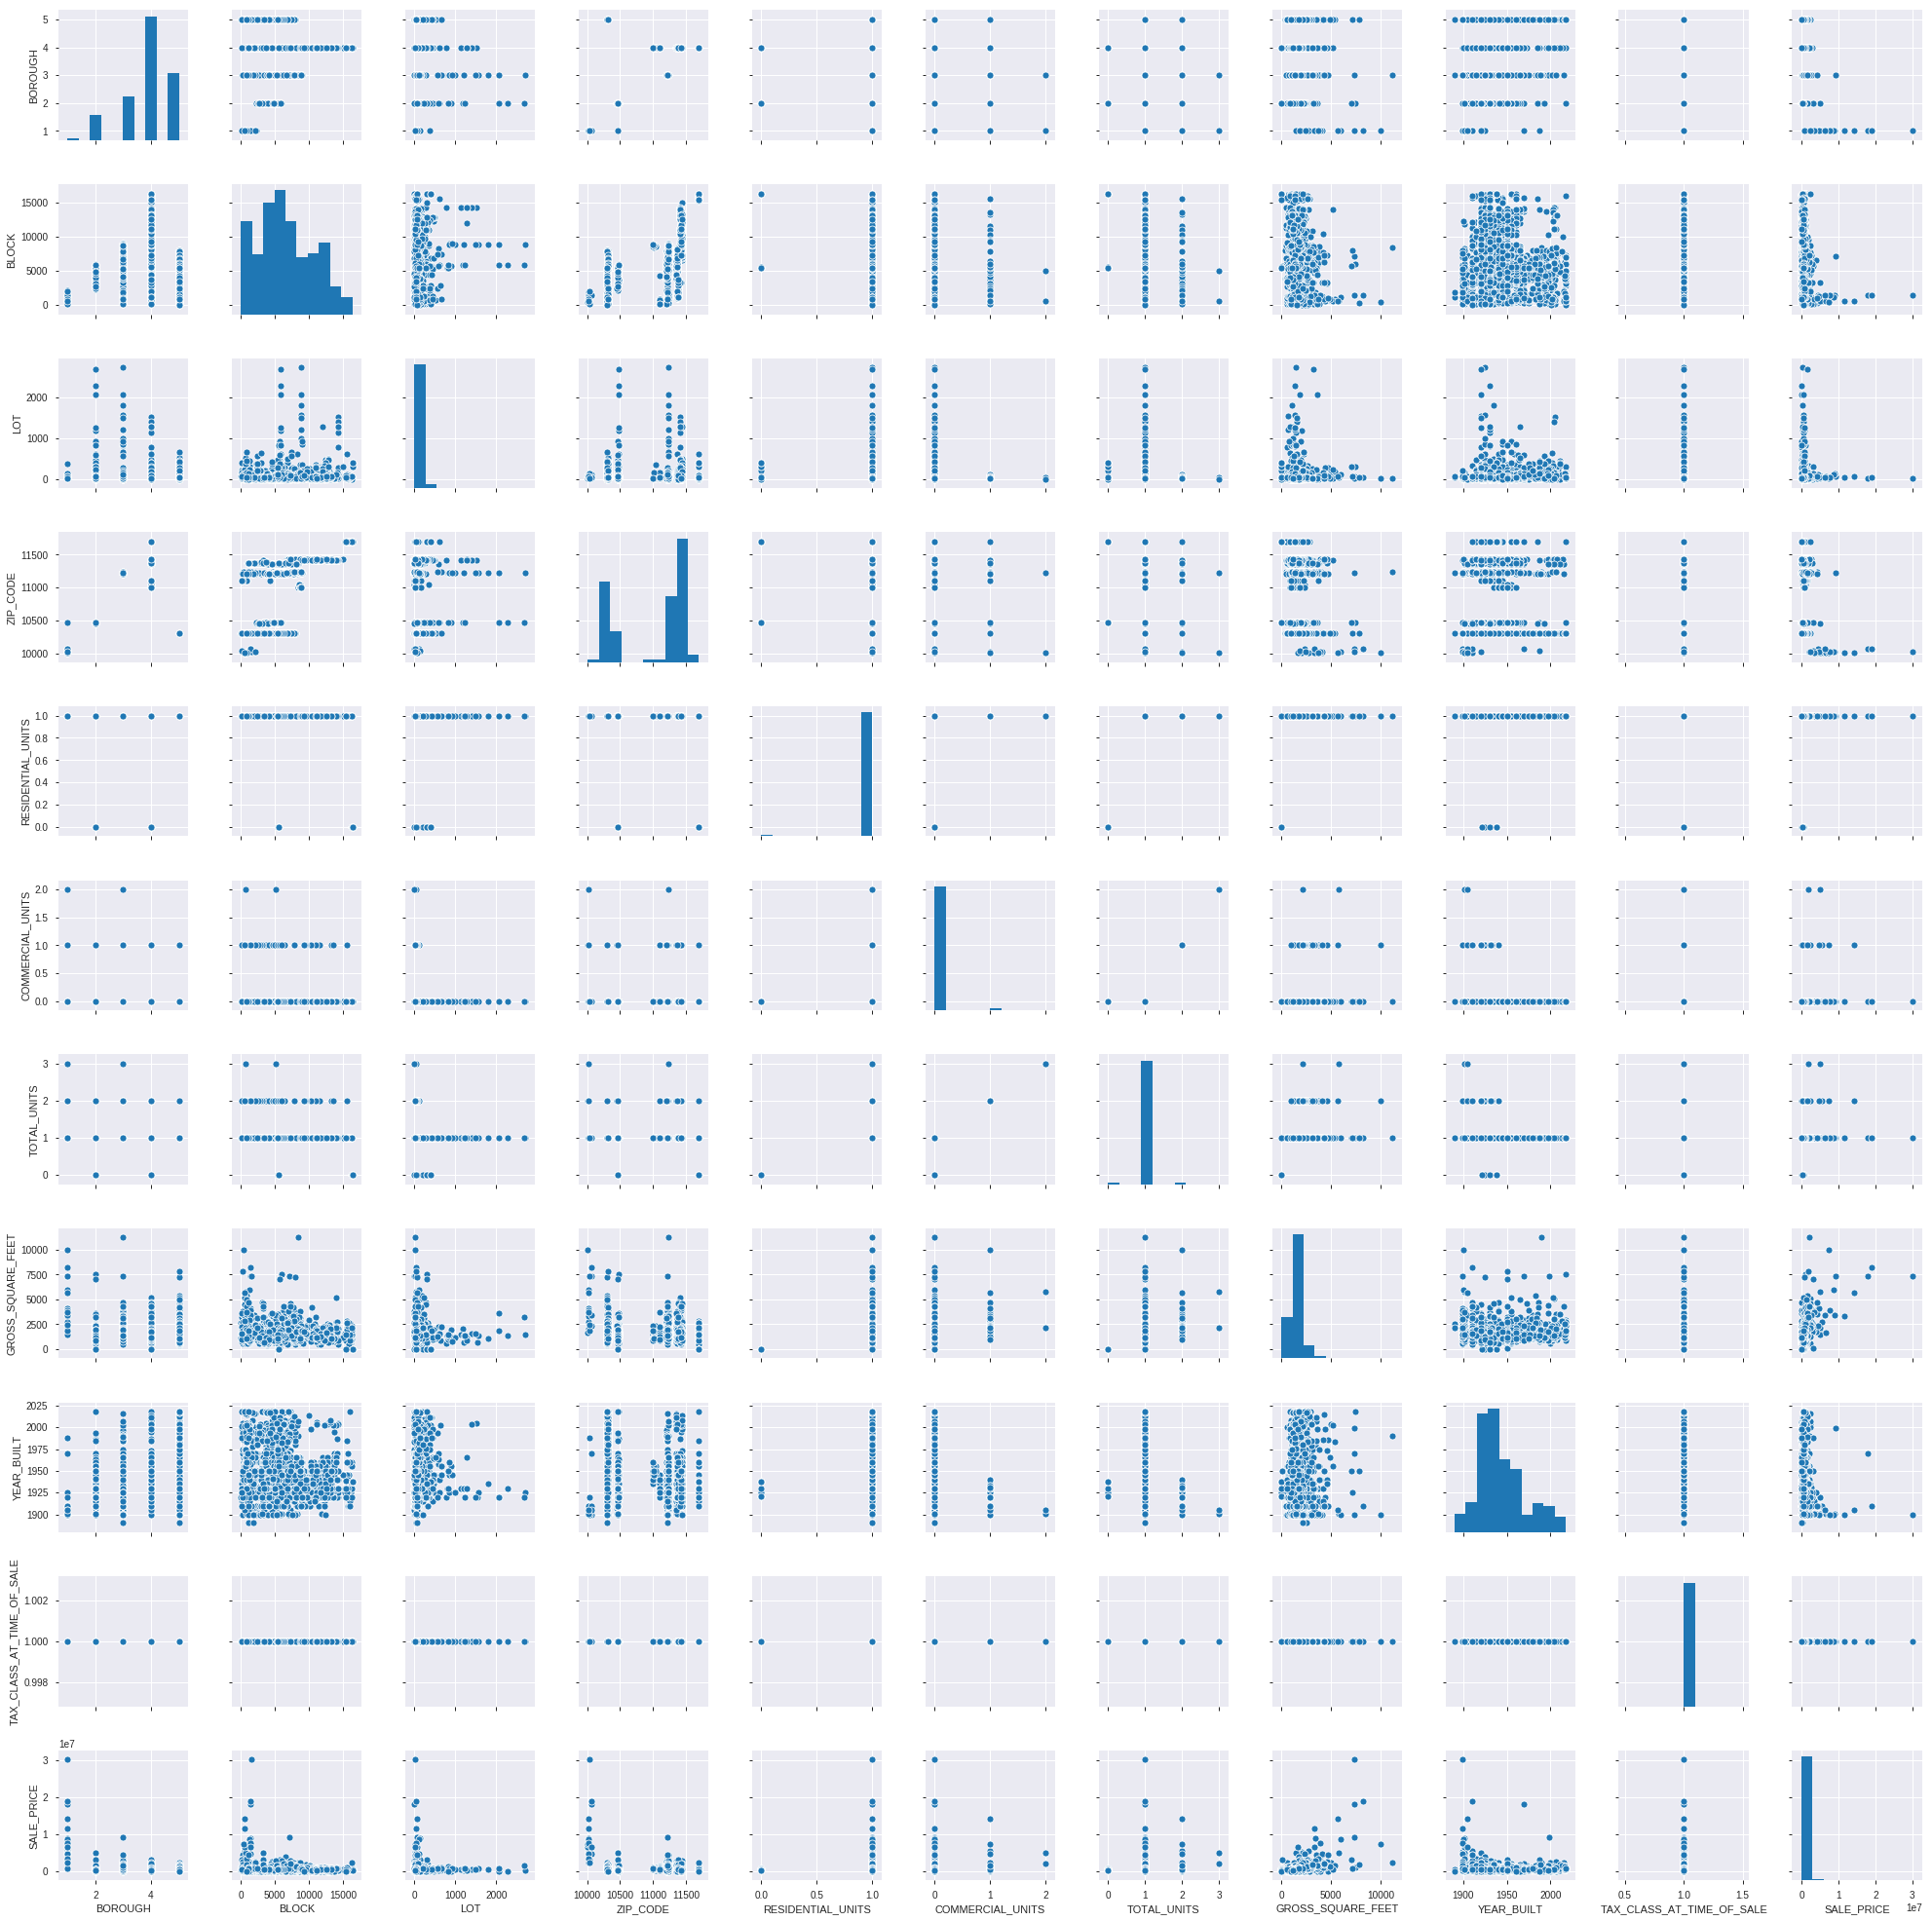

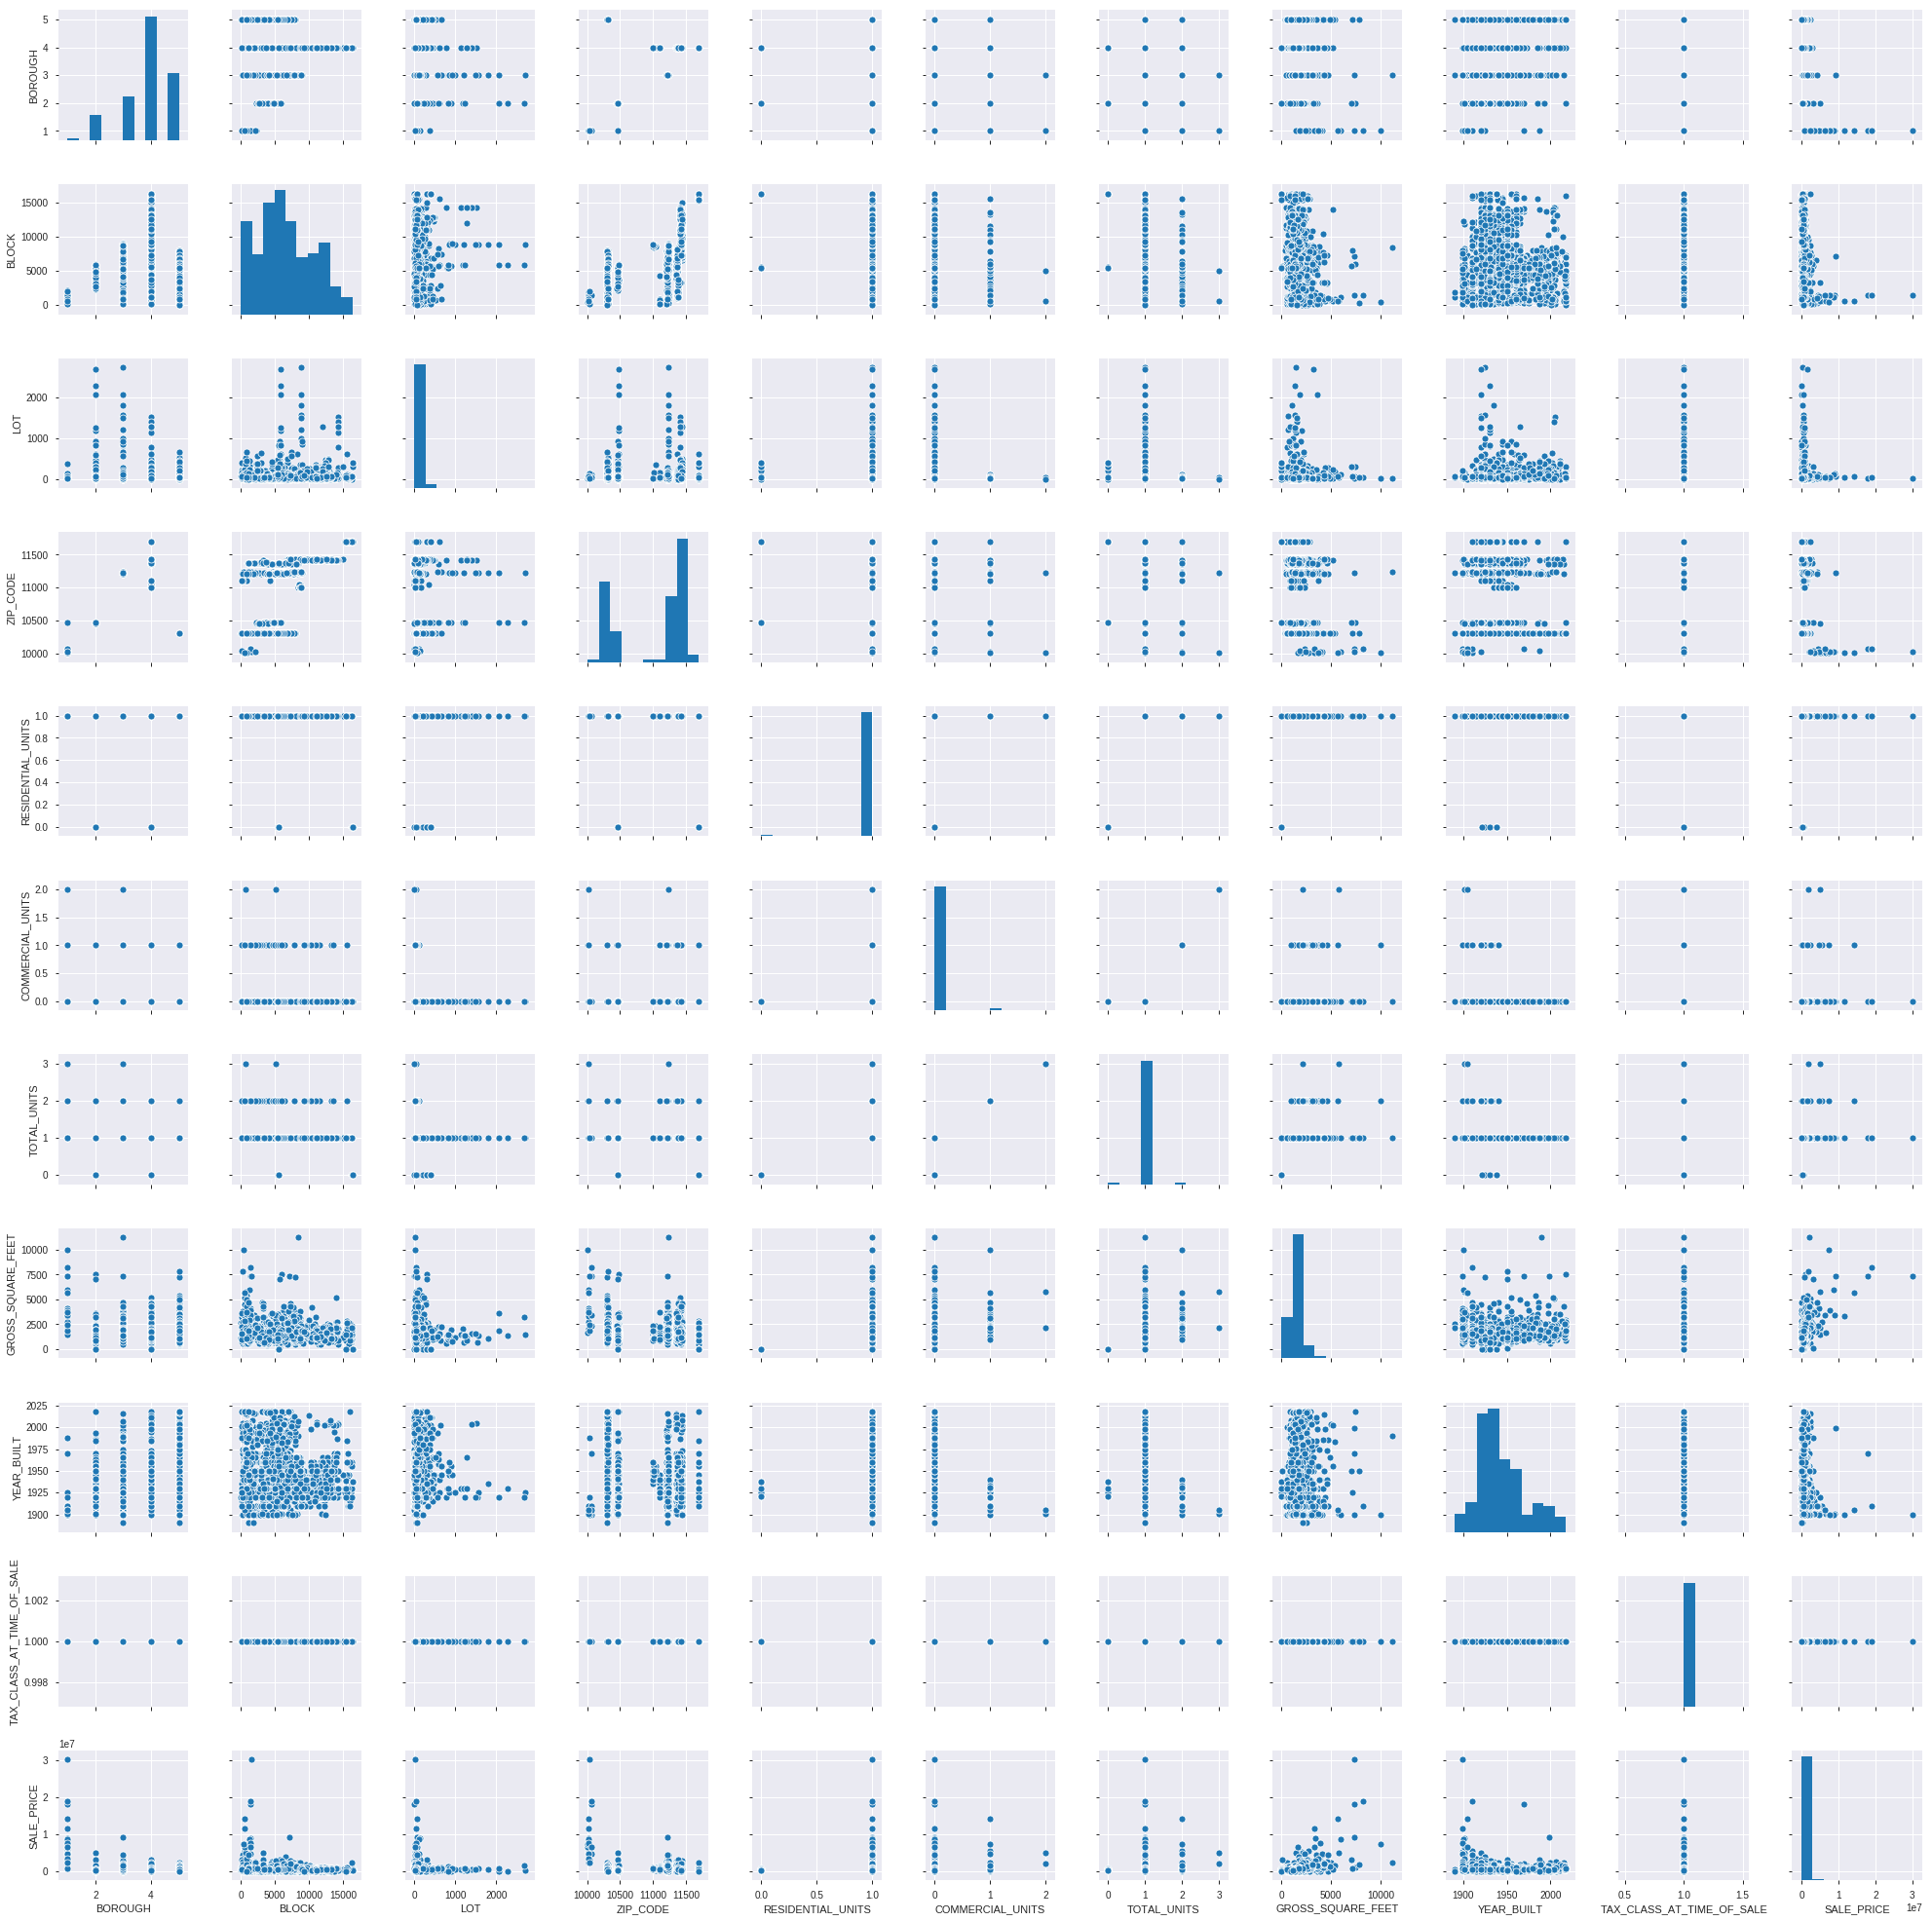

In [48]:
# sns.pairplot(df_train, vars = ['BOROUGH','BLOCK','LOT','ZIP_CODE'])

sns.pairplot(df_train, vars =['BOROUGH','BLOCK','LOT','ZIP_CODE','RESIDENTIAL_UNITS',
                              'COMMERCIAL_UNITS','TOTAL_UNITS','GROSS_SQUARE_FEET',
                              'YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE','SALE_PRICE']);

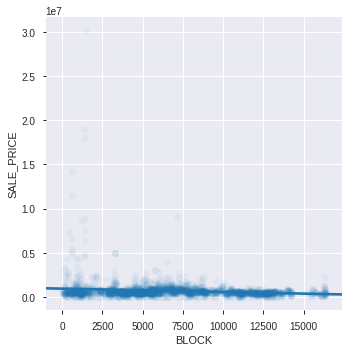

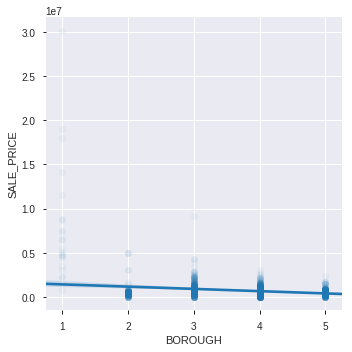

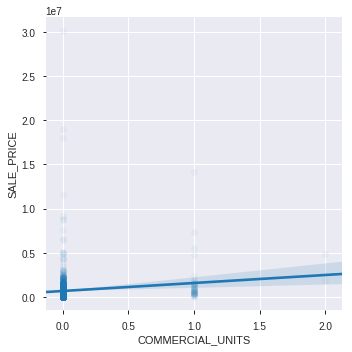

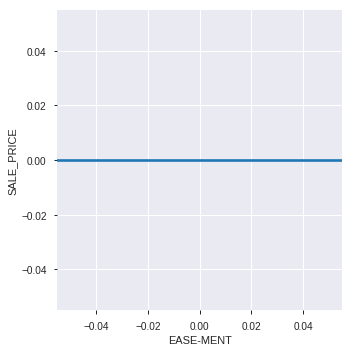

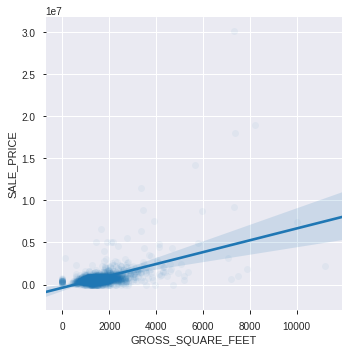

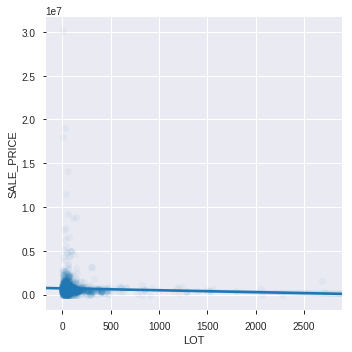

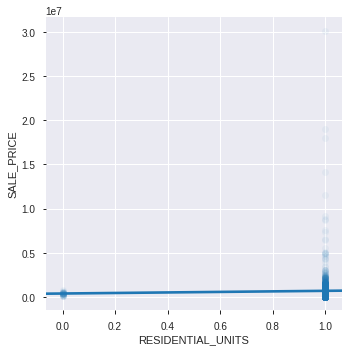

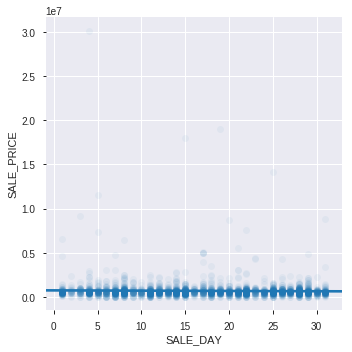

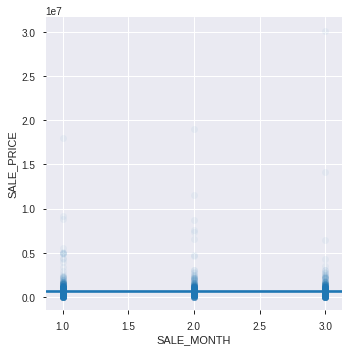

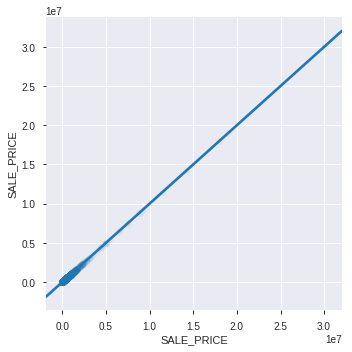

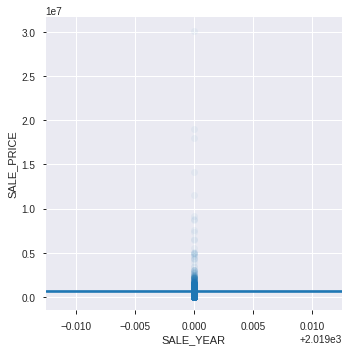

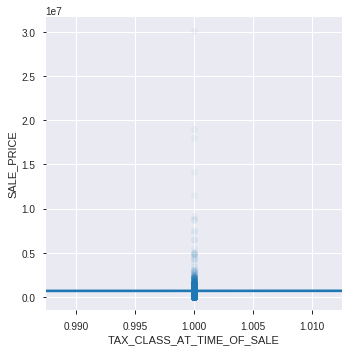

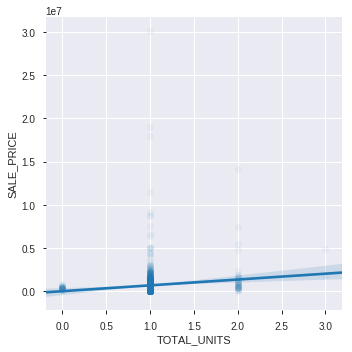

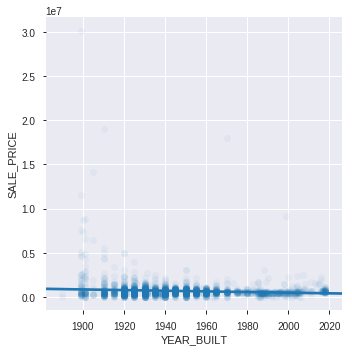

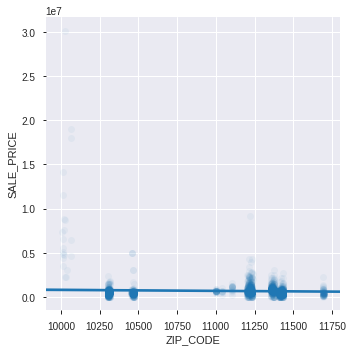

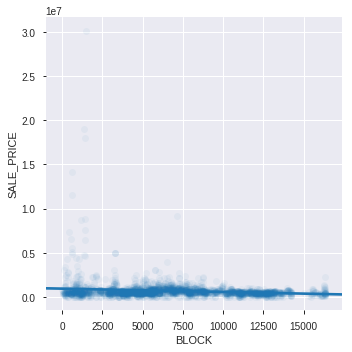

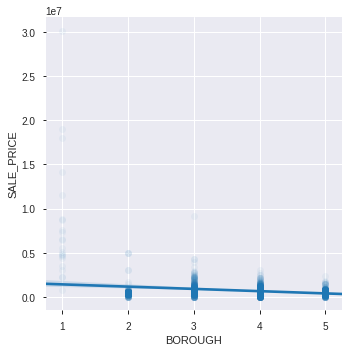

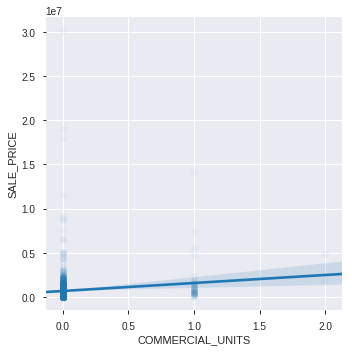

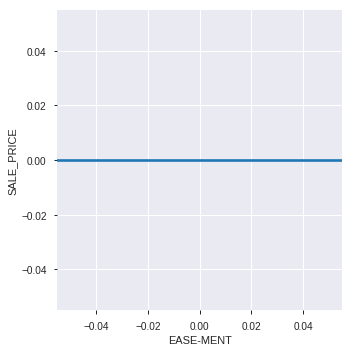

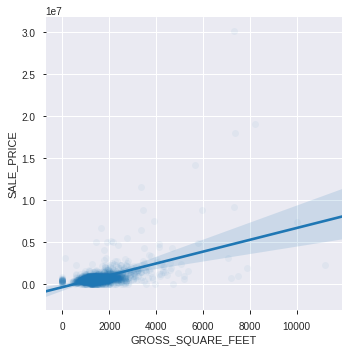

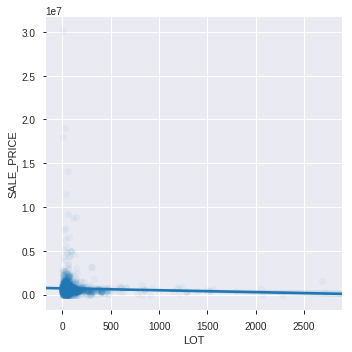

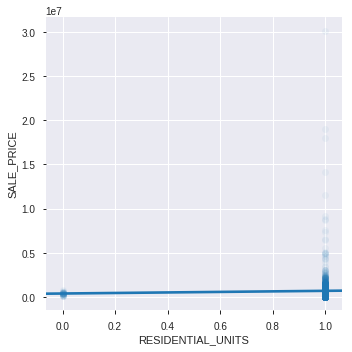

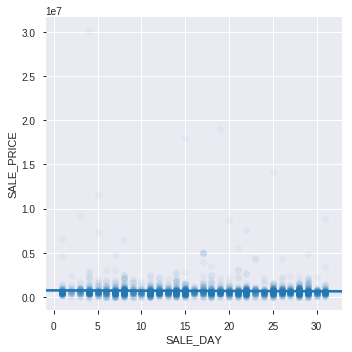

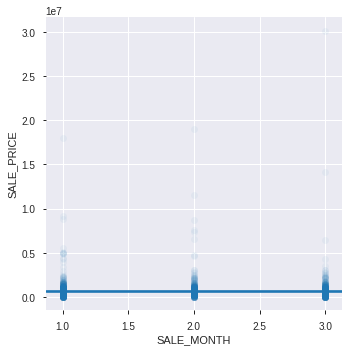

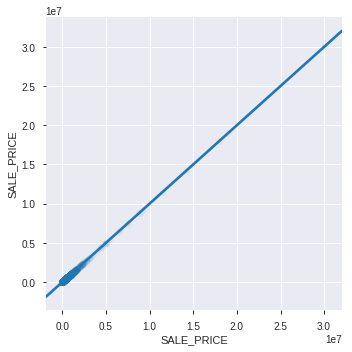

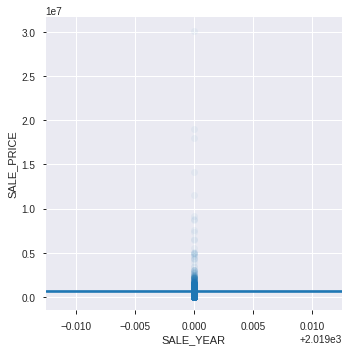

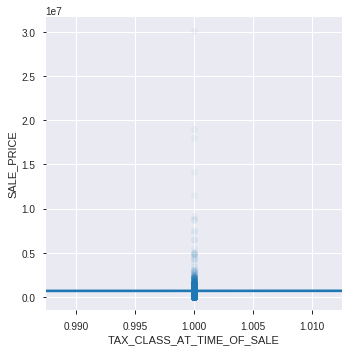

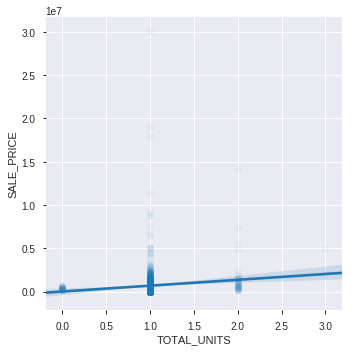

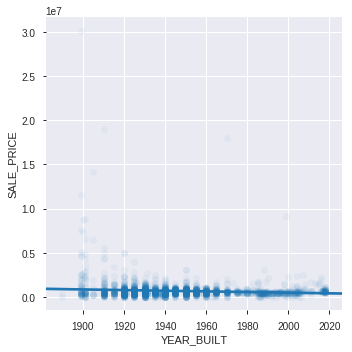

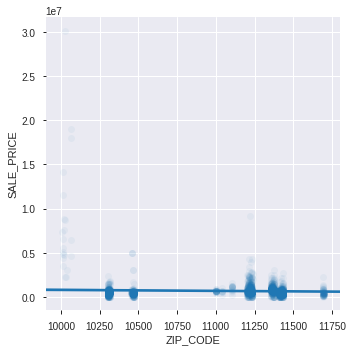

In [49]:
numeric = df_train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='SALE_PRICE', data=df_train, scatter_kws=dict(alpha=.05))

In [50]:
# Checking for number of unique values per columns
for col in sorted(df_train.columns):
  print(col)
  print(df_train[col].nunique())
  

ADDRESS
2688
APARTMENT_NUMBER
2
BLOCK
2202
BOROUGH
5
BUILDING_CLASS_AT_PRESENT
15
BUILDING_CLASS_AT_TIME_OF_SALE
12
BUILDING_CLASS_CATEGORY
1
COMMERCIAL_UNITS
3
EASE-MENT
0
GROSS_SQUARE_FEET
990
LAND_SQUARE_FEET
955
LOT
316
NEIGHBORHOOD
197
RESIDENTIAL_UNITS
2
SALE_DATE
75
SALE_DAY
31
SALE_MONTH
3
SALE_PRICE
972
SALE_YEAR
1
TAX_CLASS_AT_PRESENT
3
TAX_CLASS_AT_TIME_OF_SALE
1
TOTAL_UNITS
4
YEAR_BUILT
86
ZIP_CODE
139
ADDRESS
2688
APARTMENT_NUMBER
2
BLOCK
2202
BOROUGH
5
BUILDING_CLASS_AT_PRESENT
15
BUILDING_CLASS_AT_TIME_OF_SALE
12
BUILDING_CLASS_CATEGORY
1
COMMERCIAL_UNITS
3
EASE-MENT
0
GROSS_SQUARE_FEET
990
LAND_SQUARE_FEET
955
LOT
316
NEIGHBORHOOD
197
RESIDENTIAL_UNITS
2
SALE_DATE
75
SALE_DAY
31
SALE_MONTH
3
SALE_PRICE
972
SALE_YEAR
1
TAX_CLASS_AT_PRESENT
3
TAX_CLASS_AT_TIME_OF_SALE
1
TOTAL_UNITS
4
YEAR_BUILT
86
ZIP_CODE
139


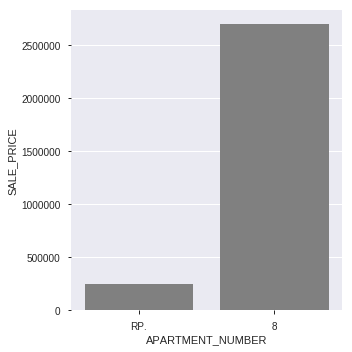

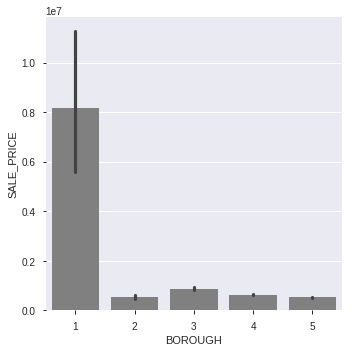

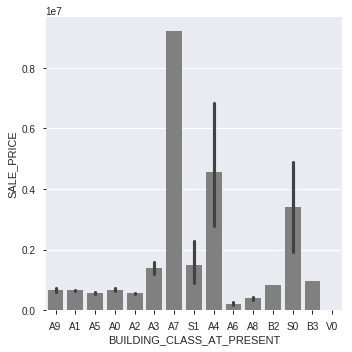

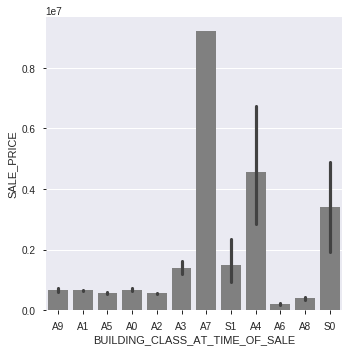

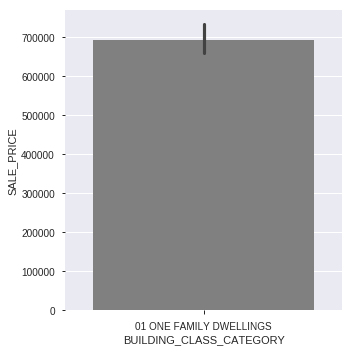

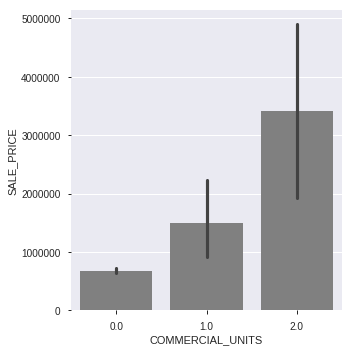

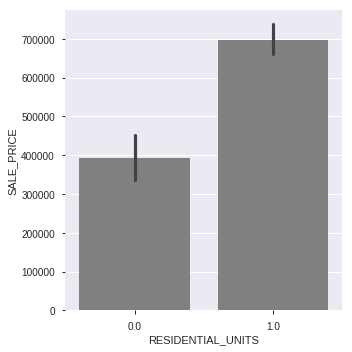

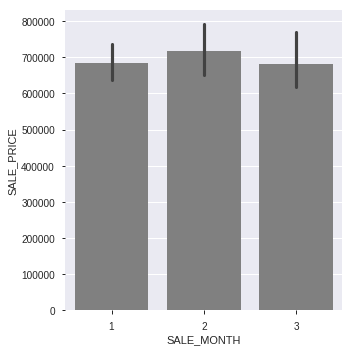

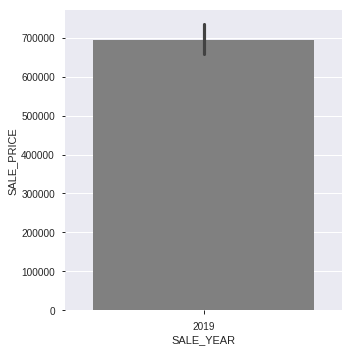

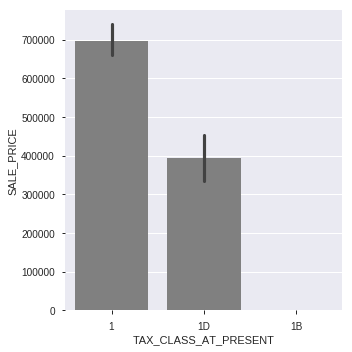

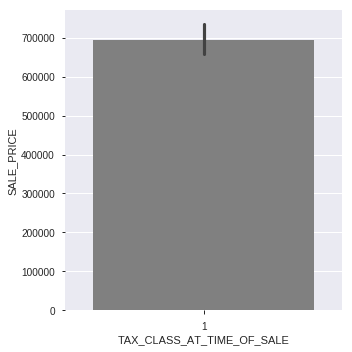

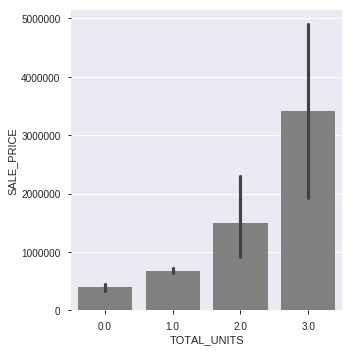

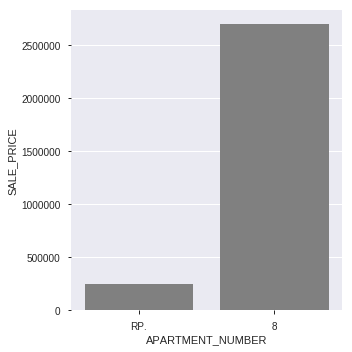

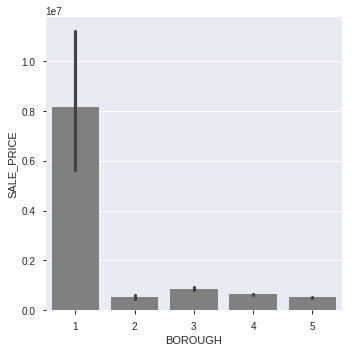

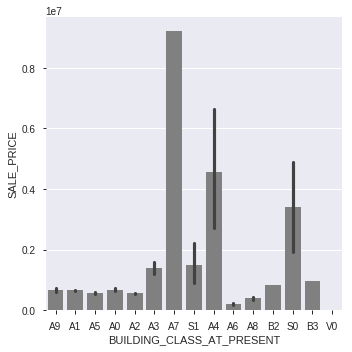

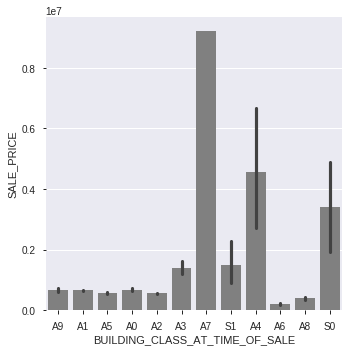

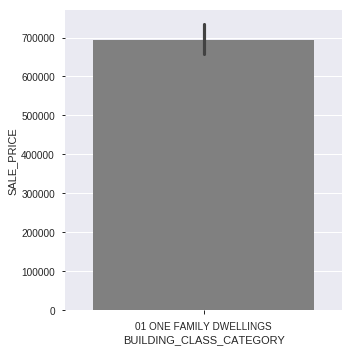

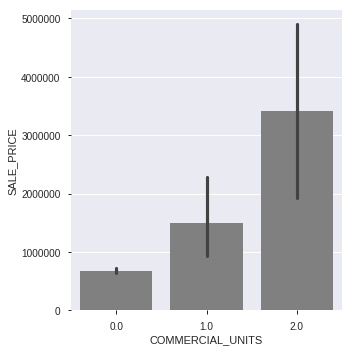

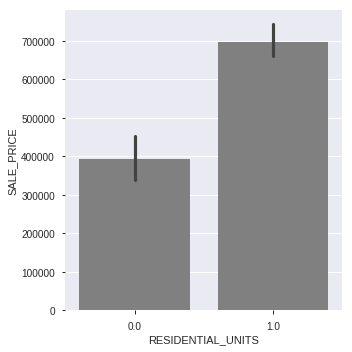

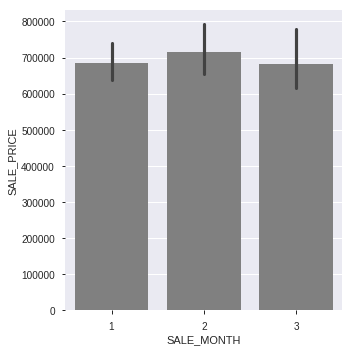

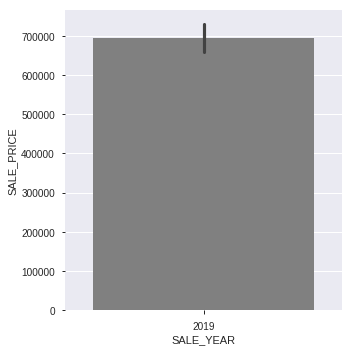

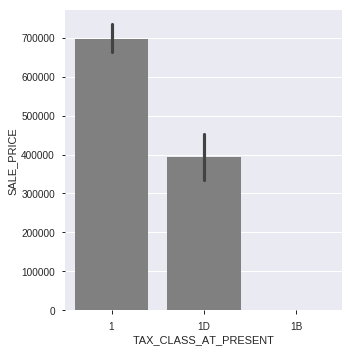

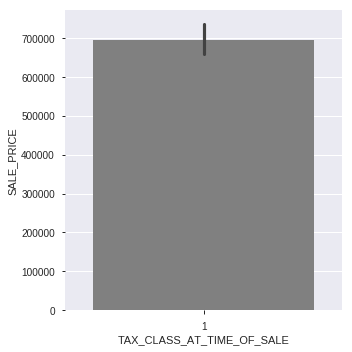

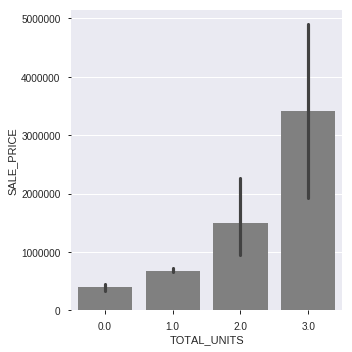

In [51]:
for col in sorted(df_train.columns):
    if 0 < df_train[col].nunique() < 16:
        sns.catplot(x=col, y='SALE_PRICE', data=df_train, kind='bar', color='grey')
        plt.show()

 # Do one-hot encoding of categorical features.

In [52]:
df_train.describe(exclude = 'number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2704,2704,2704,2704,2704,2,2704,2704,2704
unique,197,1,3,15,2688,2,955,12,75
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,33 BAILEY PLACE,RP.,"4,000",A1,2019-01-31 00:00:00
freq,79,2704,2672,978,2,1,244,978,81
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2704,2704,2704,2704,2704,2,2704,2704,2704
unique,197,1,3,15,2688,2,955,12,75
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,33 BAILEY PLACE,RP.,"4,000",A1,2019-01-31 00:00:00
freq,79,2704,2672,978,2,1,244,978,81
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [53]:
df_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SALE_MONTH,SALE_YEAR,SALE_DAY
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01,1,2019,1
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01,1,2019,1
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02,1,2019,2
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02,1,2019,2
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02,1,2019,2


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SALE_MONTH,SALE_YEAR,SALE_DAY
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01,1,2019,1
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01,1,2019,1
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02,1,2019,2
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02,1,2019,2
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02,1,2019,2


In [54]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(df_train['BUILDING_CLASS_AT_TIME_OF_SALE'])
encoded.head()

,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0,0
78,0,1,0,0,0,0,0,0,0,0,0,0
108,0,1,0,0,0,0,0,0,0,0,0,0
111,0,0,1,0,0,0,0,0,0,0,0,0


,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0,0
78,0,1,0,0,0,0,0,0,0,0,0,0
108,0,1,0,0,0,0,0,0,0,0,0,0
111,0,0,1,0,0,0,0,0,0,0,0,0


In [55]:
df.BUILDING_CLASS_AT_TIME_OF_SALE.value_counts()

A1    1252
A5    1038
A2     525
A9     258
A0      86
A3      56
S1      56
A4      45
A8      42
A6      18
A7       2
S0       2
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

A1    1252
A5    1038
A2     525
A9     258
A0      86
A3      56
S1      56
A4      45
A8      42
A6      18
A7       2
S0       2
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [56]:
df_train.isna().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         2704
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  2702
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
SALE_MONTH                           0
SALE_YEAR                            0
SALE_DAY                             0
dtype: int64

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         2704
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  2702
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
SALE_MONTH                           0
SALE_YEAR                            0
SALE_DAY                             0
dtype: int64

 # Do feature selection with SelectKBest.

In [57]:
train_subset = df_train.select_dtypes('number').dropna(axis='columns')
test_subset = df_test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2704, 13), (2704,), (676, 13), (676,))

((2704, 13), (2704,), (676, 13), (676,))

In [58]:
from sklearn.feature_selection import f_regression, SelectKBest

#Selected the 5 best/most correlative features w.r.t. the target
selector = SelectKBest(score_func = f_regression, k=1)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



((2704, 1), (676, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



((2704, 1), (676, 1))

In [59]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
  print(name)

print('\nFeatures not selected:')
for name in unselected_names:
  print(name)

Features selected:
GROSS_SQUARE_FEET

Features not selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
SALE_MONTH
SALE_YEAR
SALE_DAY
Features selected:
GROSS_SQUARE_FEET

Features not selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
SALE_MONTH
SALE_YEAR
SALE_DAY


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $349,258


 # Fit a linear regression model with multiple features.


In [71]:
from sklearn.linear_model import LinearRegression

# Looking for its error value
model = LinearRegression()

# Assign X matrix and y vector
# features = ['dogs_cats','amenities', 'longitutde/latitude', 'bed_bath']
features = ['GROSS_SQUARE_FEET','BOROUGH']
target = 'SALE_PRICE'


X = df[features]
y = df[target]
model.fit(X,y)

# y_pred = model.predict(X)


df['Predicted'] = y_pred
df['Error'] = y_pred - y

ValueError: ignored

In [72]:
df[features].dtypes

GROSS_SQUARE_FEET    float64
BOROUGH                int64
dtype: object

In [73]:
df[features].shape, df[target].shape

((3380, 2), (3380,))

In [74]:
model.intercept_, model.coef_

(356198.1371021293, array([    749.6496802 , -205810.47436479]))

In [0]:
x = df[features]
y = df[target]
y_pred = model.coef_*x + model.intercept_


In [76]:
y_pred.shape, y.shape

((3380, 2), (3380,))

In [77]:
    
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R^2:', r2)

ValueError: ignored

 # Get mean absolute error for the test set.